# Imports / Set up

In [44]:
from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from operator_aliasing.data.utils import get_data
from operator_aliasing.data.utils import get_dataset
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.utils import load_latest_ckpt
from operator_aliasing.utils import get_energy_curve
from operator_aliasing.utils import get_model_preds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

FIG_DIR = '../figures'

ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'

device=device(type='cuda')


# Aliasing Overview

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-07_15_05_l1_128_darcy_pdebench_-1_-1_128_64_FNO2D_1_1/150_ckpt.pth


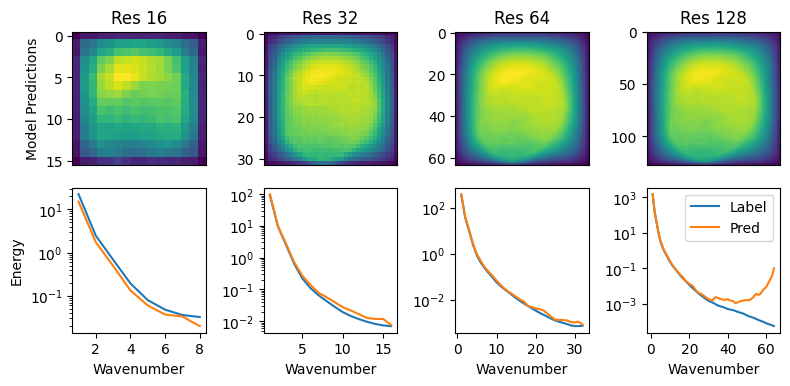

In [38]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
from matplotlib import ticker

# grab trained model
loss = 'l1'
batch_size = 128
dataset_name = 'darcy_pdebench'
img_size = 128
max_mode = img_size // 2
batch_size = 128
in_channels = 1
out_channels = 1
initial_steps = 1
filter_lim = -1
downsample_dim = -1
lr = '0001'
wd = 1e-7
model_name = 'FNO2D'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

for x_idx, res in enumerate([16, 32, 64, 128]):
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=filter_lim,
        img_size=res,
        downsample_dim=downsample_dim,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
    )
    sample = dataset[0]
    # grab a single input from the last batch
    model_input = sample['x'].unsqueeze(dim=0).to(device)
    with torch.no_grad():
        model_output = model(x=model_input)
    ground_truth = sample['y'].unsqueeze(dim=0)

    # convert to plotable form
    model_in = model_input[0, 0, :, :].cpu().numpy()
    output = model_output[0, 0, :, :].cpu().numpy()
    label = ground_truth[0, 0, :, :].cpu().numpy()

    axs[0, x_idx].imshow(output)
    axs[0, x_idx].set_title(f'Res {res}')
    # axs[0, x_idx].get_yaxis().set_visible(False)
    axs[0, x_idx].get_xaxis().set_visible(False)

    label_spectrum = get_energy_curve(ground_truth[0])
    pred_spectrum = get_energy_curve(model_output[0])

    axs[1, x_idx].set_yscale('log')
    x = np.linspace(1, res // 2, res // 2)
    axs[1, x_idx].plot(x, label_spectrum, label='Label')
    axs[1, x_idx].plot(x, pred_spectrum, label='Pred')
    axs[1, x_idx].set_xlabel('Wavenumber')
    # plt.locator_params(axis="x", integer=True, tight=True)
    axs[1, x_idx].xaxis.set_major_locator(
        ticker.MaxNLocator(integer=True, nbins=4)
    )
    if x_idx == 0:
        axs[1, x_idx].set_ylabel('Energy')
        axs[0, x_idx].set_ylabel('Model Predictions')

plt.legend()
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/aliasing_overview.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-07_15_05_l1_128_darcy_pdebench_-1_-1_128_64_FNO2D_1_1/150_ckpt.pth


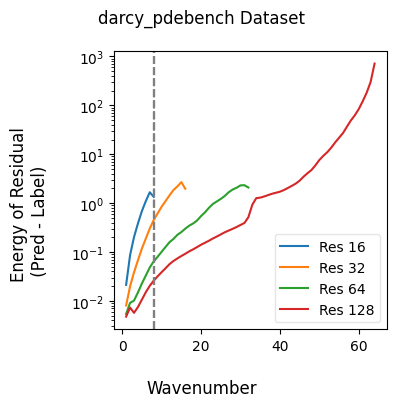

In [62]:
# Average Error Spectrum (Figure 2)

# grab trained model
loss = 'l1'
batch_size = 128
dataset_name = 'darcy_pdebench'
img_size = 128
max_mode = img_size // 2
batch_size = 128
in_channels = 1
out_channels = 1
initial_steps = 1
filter_lim = -1
downsample_dim = -1
lr = '0001'
wd = 1e-7
model_name = 'FNO2D'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
seed = 0
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey='row')

for idx, s in enumerate([16, 32, 64, 128]):
    train_loader, test_loaders = get_data(
        dataset_name=dataset_name,
        filter_lim=filter_lim,
        img_size=s,
        downsample_dim=downsample_dim,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        seed=seed,
        batch_size=batch_size,
    )
    test_loader = test_loaders['test']

    # squeeze the dataset to remove the empty channel dimension
    model_preds_test = get_model_preds(test_loader, model, device).squeeze()
    shape = model_preds_test.shape

    test_sp_y = get_energy_curve(
        test_loader.dataset[:]['y'].squeeze().reshape(shape[0], s, s),
        s,
    )

    # compute residuals
    residuals = []
    for i in range(model_preds_test.shape[0]):
        residual = (
            model_preds_test[i].to('cpu')
            - test_loader.dataset[:]['y'].squeeze()[i]
        )
        residuals.append(residual)

    residuals = torch.stack(residuals)

    # Generate the spectrum of the dataset
    # We reshape our samples into the form expected by ``spectrum_2d``:
    # ``(n_samples, h, w)``
    # spectrum of residuals
    residual_spectrum = get_energy_curve(
        residuals  # .reshape(samples * 1, s, s)
    )

    # Configure pyplot and generate the plot
    ax.set_yscale('log')
    x = np.linspace(1, s // 2, s // 2)
    ax.plot(
        # abs(test_sp_model_pred - test_sp_y) / test_sp_y,
        x,
        residual_spectrum / test_sp_y,
        linestyle='-',
        label=f'Res {s}',
    )
    ax.axvline(x=8, color='grey', linestyle='--')

    fig.suptitle(f'{dataset_name} Dataset')

fig.supxlabel('Wavenumber')
fig.supylabel('Energy of Residual \n (Pred - Label)')

# show the figure
leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.5)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/higher_res_residual_spectrum.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

# Compound aliasing over time w/ Burgers/ Incompressible NS

TODO: show that aliasing gets worse over time w/ autoregressive inference

# PINNs

TODO: show that physics informed losses do not help

# Filter/ Downsample Experiments

TODO: show that w/ filters/downsampling the 

# HP Search

Find optimial HP config for darcy, burgers, and incompressible navier stokes

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


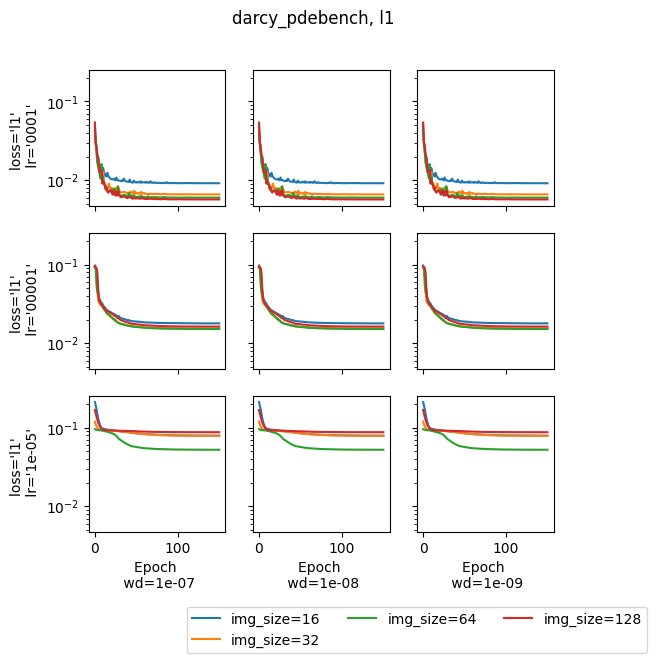

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


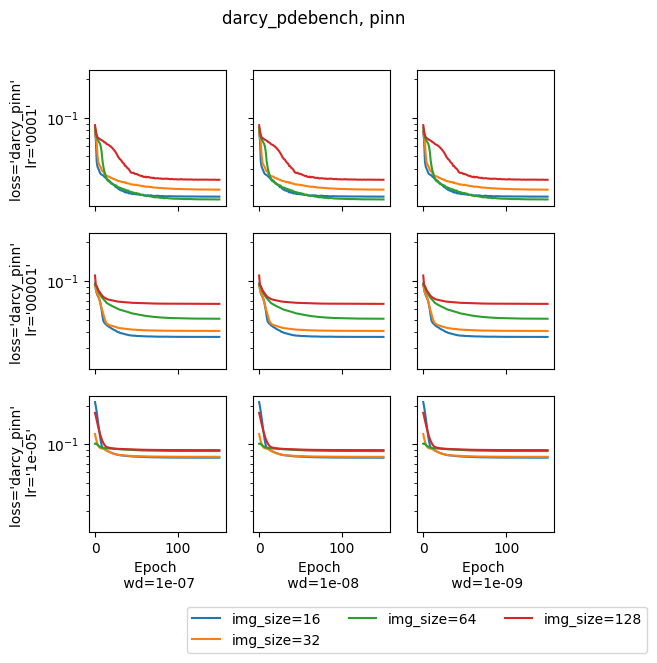

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


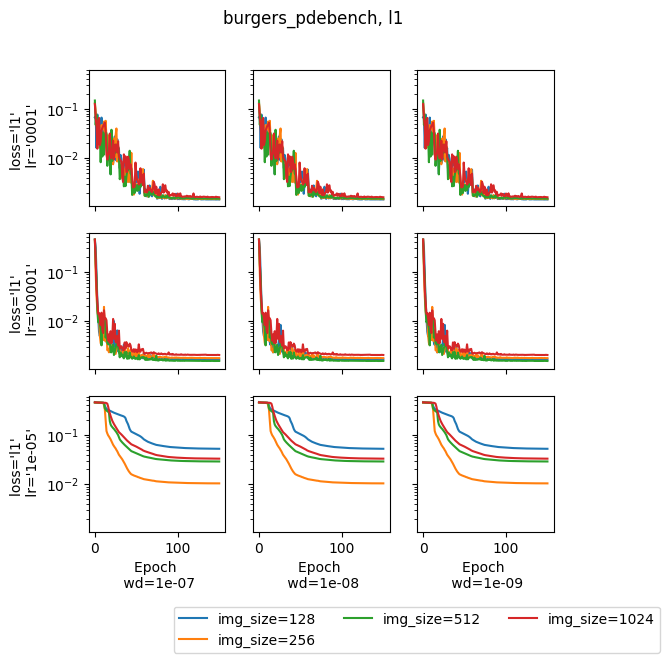

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


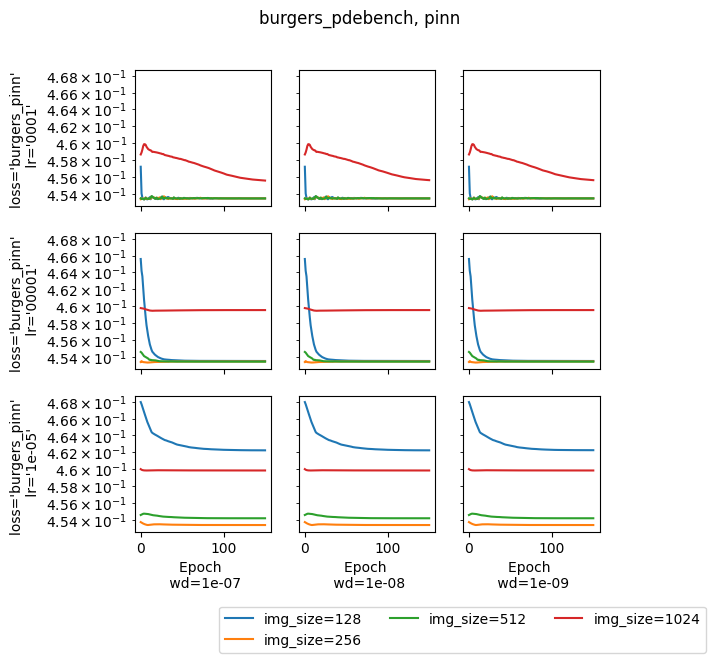

does not exist:  0001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10


/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


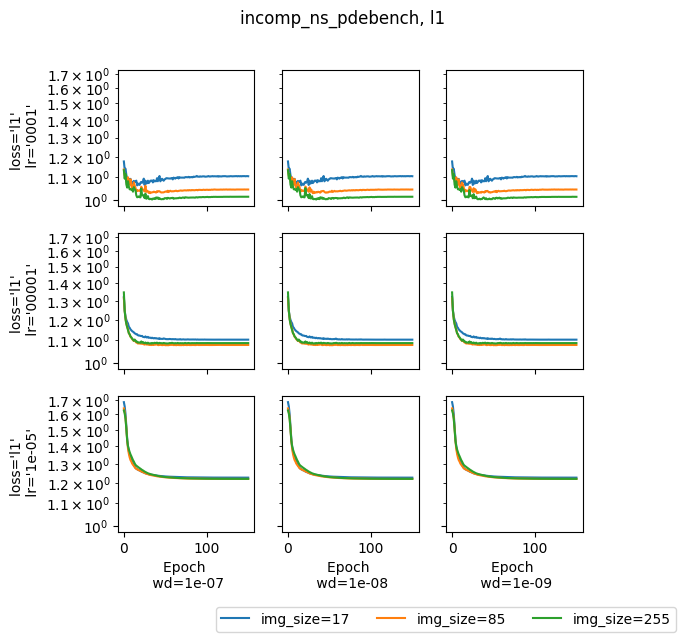

does not exist:  0001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10


/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


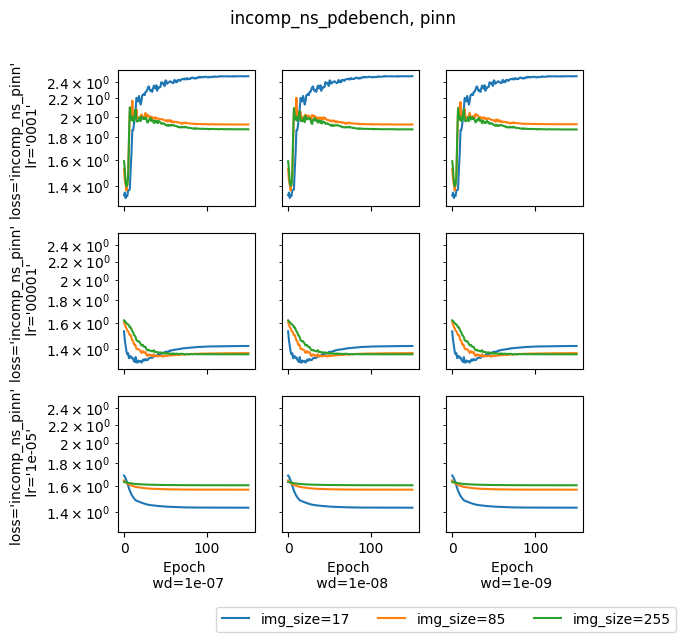

finished_exp=198, total_exp=216, 0.9166666666666666 %


In [3]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
]:
    model_name = 'FNO2D'
    in_channels = 10
    initial_steps = 10

    if dataset_name == 'darcy_pdebench':
        img_sizes = [16, 32, 64, 128]
        pinn_loss_name = 'darcy_pinn'
        batch_size = 128
        in_channels = 1
        initial_steps = 1

    if dataset_name == 'burgers_pdebench':
        img_sizes = [128, 256, 512, 1024]
        pinn_loss_name = 'burgers_pinn'
        batch_size = 64
        model_name = 'FNO1D'

    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [17, 85, 255, 510]
        pinn_loss_name = 'incomp_ns_pinn'
        batch_size = 4

    for loss_type in ['l1', 'pinn']:
        loss = 'l1'
        if loss_type == 'pinn':
            loss = pinn_loss_name
        fig, axes = plt.subplots(
            nrows=3, ncols=3, sharey=True, sharex='col', figsize=(6, 6)
        )
        for y_idx, lr in enumerate(['0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-07, 1e-08, 1e-09]):
                for color_idx, img_size in enumerate(img_sizes):
                    max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    total_exp += 1
                    if not os.path.exists(ckpt_name):
                        print('does not exist: ', ckpt_dir)
                        continue
                    df = pd.read_csv(ckpt_name)
                    for ylabel in [
                        #'train_loss',
                        'test',
                    ]:
                        if 150 in df['epoch']:
                            finished_exp += 1
                        sns.lineplot(
                            df,
                            x='epoch',
                            y=ylabel,
                            label=f'{img_size=}',
                            ax=axes[y_idx, x_idx],
                        )
                        axes[y_idx, x_idx].get_legend().remove()
                        axes[y_idx, x_idx].set_yscale('log')

                if y_idx == 2:
                    axes[y_idx, x_idx].set_xlabel(f'Epoch \n {wd=}')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(f'{loss=} \n {lr=}')

        plt.legend(bbox_to_anchor=(0, -0.5), loc='upper center', ncols=3)
        plt.tight_layout()
        fig.suptitle(f'{dataset_name}, {loss_type}')
        plt.show()
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp} %')